In [60]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

%matplotlib inline

### Load Training Data

In [48]:
dir_train = "./2019Proj2_train/"
filenames = np.array(os.listdir(dir_train))
gestures = ["beat3", "beat4", "circle", "eight", "inf", "wave"]

train_lists = {}
for g in gestures:
    train_lists[g] = np.array([t for t in filenames if t.startswith(g)])
    print g, train_lists[g]

train_X = {}
for g in gestures:
    train_X[g] = []
    for fname in train_lists[g]:
        train_X[g].append(np.genfromtxt(os.path.join(dir_train, fname), delimiter='\t'))
        print fname, train_X[g][-1].shape
    train_X[g] = np.array(train_X[g])

beat3 ['beat3_01.txt' 'beat3_02.txt' 'beat3_03.txt' 'beat3_06.txt'
 'beat3_08.txt']
beat4 ['beat4_01.txt' 'beat4_03.txt' 'beat4_05.txt' 'beat4_08.txt'
 'beat4_09.txt']
circle ['circle12.txt' 'circle13.txt' 'circle14.txt' 'circle17.txt'
 'circle18.txt']
eight ['eight01.txt' 'eight02.txt' 'eight04.txt' 'eight07.txt' 'eight08.txt']
inf ['inf11.txt' 'inf112.txt' 'inf13.txt' 'inf16.txt' 'inf18.txt']
wave ['wave01.txt' 'wave02.txt' 'wave03.txt' 'wave05.txt' 'wave07.txt']
beat3_01.txt (2220, 7)
beat3_02.txt (2608, 7)
beat3_03.txt (2643, 7)
beat3_06.txt (2865, 7)
beat3_08.txt (3095, 7)
beat4_01.txt (3017, 7)
beat4_03.txt (3088, 7)
beat4_05.txt (2307, 7)
beat4_08.txt (2613, 7)
beat4_09.txt (3009, 7)
circle12.txt (1944, 7)
circle13.txt (2354, 7)
circle14.txt (2133, 7)
circle17.txt (2295, 7)
circle18.txt (1901, 7)
eight01.txt (2391, 7)
eight02.txt (3148, 7)
eight04.txt (3371, 7)
eight07.txt (2633, 7)
eight08.txt (2758, 7)
inf11.txt (1983, 7)
inf112.txt (3379, 7)
inf13.txt (2495, 7)
inf16.txt (212

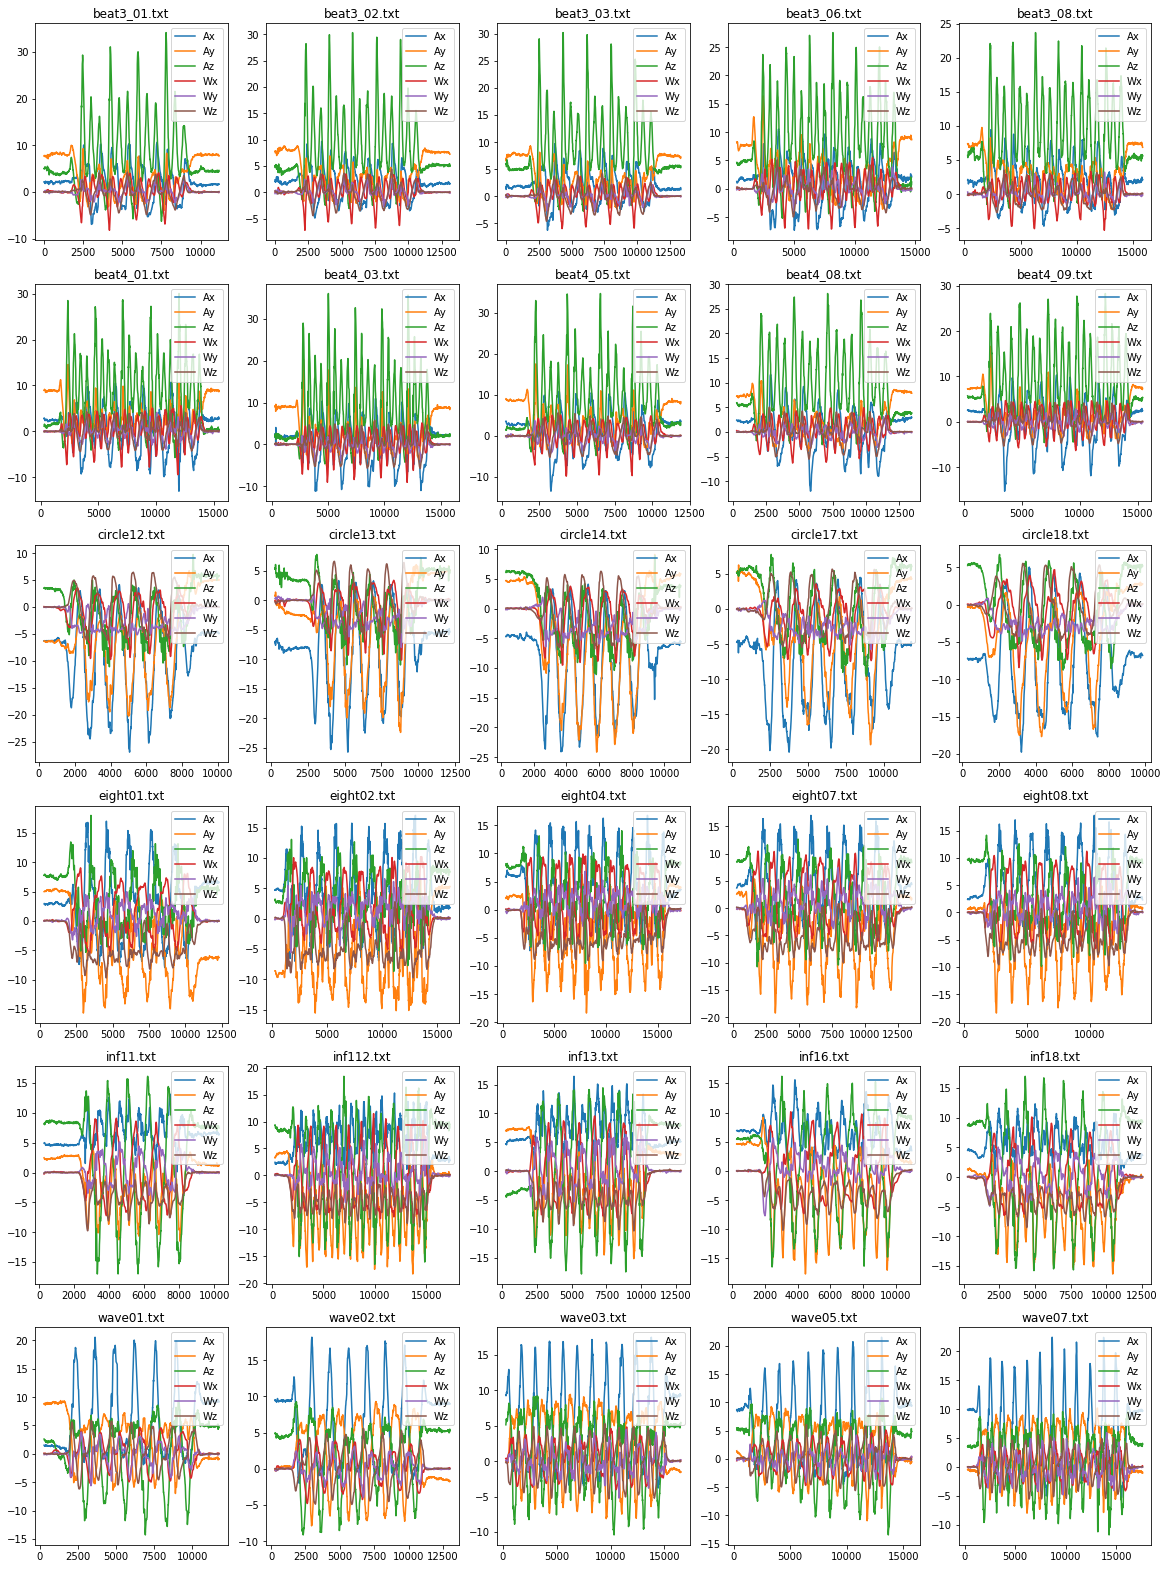

In [39]:
PLT_COL = len(train_X[g])
PLT_ROW = len(gestures)

plt.figure(figsize=[20, 28])
row, col = 0, 1
for g in gestures:
    col = 1
    for data in train_X[g]:
        plt.subplot(PLT_ROW, PLT_COL, row * PLT_COL + col)
        plt.title(train_lists[g][col - 1])
        plt.plot(data[:, 0], data[:, 1:])
        plt.legend(["Ax", "Ay", "Az", "Wx", "Wy", "Wz"], loc=1)
        col += 1
    row += 1

### Hold out 20% for dev testing

In [127]:
split_ratio = 0.2

dev_test_indices = {}
x_train_dev = {}
x_test_dev = {}
file_train_dev = {}
file_test_dev = {}

for g in gestures:
    test_size = int(len(train_X[g]) * split_ratio)
    dev_test_indices[g] = sorted(random.sample(range(len(train_X[g])), test_size))
    x_train_dev[g] = np.array([train_X[g][i] for i in range(len(train_X[g])) if i not in dev_test_indices[g]])
    x_test_dev[g] = np.array([train_X[g][i] for i in range(len(train_X[g])) if i in dev_test_indices[g]])
    file_train_dev[g] = np.array([train_lists[g][i] for i in range(len(train_lists[g])) if i not in dev_test_indices[g]])
    file_test_dev[g] = np.array([train_lists[g][i] for i in range(len(train_lists[g])) if i in dev_test_indices[g]])

print "Split Ratio:", 0.2

for g in gestures: 
    print "---------------------------------"
    print g, "=> test set picked:", dev_test_indices[g]
    print "training set: ", file_train_dev[g]
    print "test set: ", file_test_dev[g]

Split Ratio: 0.2
---------------------------------
beat3 => test set picked: [4]
training set:  ['beat3_01.txt' 'beat3_02.txt' 'beat3_03.txt' 'beat3_06.txt']
test set:  ['beat3_08.txt']
---------------------------------
beat4 => test set picked: [4]
training set:  ['beat4_01.txt' 'beat4_03.txt' 'beat4_05.txt' 'beat4_08.txt']
test set:  ['beat4_09.txt']
---------------------------------
circle => test set picked: [2]
training set:  ['circle12.txt' 'circle13.txt' 'circle17.txt' 'circle18.txt']
test set:  ['circle14.txt']
---------------------------------
eight => test set picked: [4]
training set:  ['eight01.txt' 'eight02.txt' 'eight04.txt' 'eight07.txt']
test set:  ['eight08.txt']
---------------------------------
inf => test set picked: [0]
training set:  ['inf112.txt' 'inf13.txt' 'inf16.txt' 'inf18.txt']
test set:  ['inf11.txt']
---------------------------------
wave => test set picked: [3]
training set:  ['wave01.txt' 'wave02.txt' 'wave03.txt' 'wave07.txt']
test set:  ['wave05.txt']


### HMM models for gesture recogition

In [145]:
X = x_train_dev[g].flatten(order='A')
print(x_train_dev[g][0].shape)
for x in X:
    print(x.shape)

(2266, 7)
(2266, 7)
(2526, 7)
(3225, 7)
(3443, 7)


In [133]:
%%time

models = {}
for g in gestures:
    models[g] = hmm.GaussianHMM(10, "full")
#     for d in x_train_dev[g]:  
#         models[g].fit(d)
    X = x_train_dev
    models[g].fit()

CPU times: user 40.1 s, sys: 5.94 s, total: 46.1 s
Wall time: 20.4 s


#### Predict

In [134]:
correct = 0
for g in gestures:
    print "--------", g, "---------"
    scores = np.array([models[m_g].score(x_test_dev[g][0]) for m_g in gestures])
    for i in range(len(scores)):
        print "{:6} ->  {}".format(gestures[i], scores[i])
        
    y_pred = gestures[np.argmax(scores)]
    print "Predict:", y_pred, "\n"
    if y_pred == g:
        correct += 1

print "accuracy: ", float(correct) / len(gestures)

-------- beat3 ---------
beat3  ->  -64870.4832264
beat4  ->  -87356.5674382
circle ->  -469305.559031
eight  ->  -180087.150807
inf    ->  -178834.031377
wave   ->  -139836.38919
Predict: beat3 

-------- beat4 ---------
beat3  ->  -76874.7029826
beat4  ->  -77669.4336409
circle ->  -522482.101256
eight  ->  -214979.405797
inf    ->  -237251.207332
wave   ->  -182364.480077
Predict: beat3 

-------- circle ---------
beat3  ->  -173896.404972
beat4  ->  -258093.082458
circle ->  -139551.991509
eight  ->  -251086.171104
inf    ->  -433597.952649
wave   ->  -615769.191632
Predict: circle 

-------- eight ---------
beat3  ->  -192862.128686
beat4  ->  -252001.214969
circle ->  -581916.710708
eight  ->  -76097.9267603
inf    ->  -177086.889837
wave   ->  -362240.205268
Predict: eight 

-------- inf ---------
beat3  ->  -86946.9805274
beat4  ->  -97121.1302989
circle ->  -356797.702262
eight  ->  -77573.2292553
inf    ->  -69526.8167781
wave   ->  -161905.185421
Predict: inf 

-------- wave